In [1]:
import sqil_core as sqil
import numpy as np
import matplotlib.pyplot as plt

In [2]:
PARAM_METADATA = {
    "frequencies": {  # FIXME: remove and replace "frequencies" in rr spec
        "name": "Readout frequency",
        "symbol": "f_{RO}",
        "unit": "Hz",
        "scale": 1e-9,
    },
    "readout_resonator_frequency": {
        "name": "Readout frequency",
        "symbol": "f_{RO}",
        "unit": "Hz",
        "scale": 1e-9,
    },
    "readout_range_in": {
        "name": "Readout power offset",
        "symbol": "P_0^{RO}",
        "unit": "dBm",
        "scale": 1,
    },
    "readout_amplitude": {
        "name": "Readout amplitude",
        "symbol": "P_{amp}^{RO}",
        "unit": "",
        "scale": 1,
    },
    "readout_length": {
        "name": "Readout length",
        "symbol": "T_{RO}",
        "unit": "s",
        "scale": 1e6,
    },
    "readout_lo_frequency": {
        "name": "Internal readout LO frequency",
        "symbol": "f_{LO-int}^{RO}",
        "unit": "Hz",
        "scale": 1e-9,
    },
    "external_lo_frequency": {
        "name": "External LO frequency",
        "symbol": "f_{LO}^{Ext}",
        "unit": "Hz",
        "scale": 1e-9,
    },
    "external_lo_power": {
        "name": "External LO power",
        "symbol": "P_{LO}^{Ext}",
        "unit": "dBm",
        "scale": 1,
    },
    "readout_kappa_tot": {
        "symbol": r"\kappa_{tot}",
        "unit": "Hz",
        "scale": "MHz"
    }
}

ONE_TONE_PARAMS = np.array(
    [
        "readout_amplitude",
        "readout_length",
        "external_lo_frequency",
        "external_lo_power",
    ]
)

Sqil core functions

In [3]:
_EXP_UNIT_MAP = {
    -15: "p",
    -12: "f",
    -9: "n",
    -6: r"\mu ",
    -3: "m",
    0: "",
    3: "k",
    6: "M",
    9: "G",
    12: "T",
    15: "P",
}

def get_name_and_unit(param_id: str) -> str:
    """Get the name and unit of measurement of a prameter, e.g. Frequency [GHz].

    Parameters
    ----------
    param : str
        Parameter ID, as defined in the param_dict.json file.

    Returns
    -------
    str
        Name and [unit]
    """
    meta = PARAM_METADATA[param_id]
    scale = meta["scale"] if "scale" in meta else 1
    exponent = -(int(f"{scale:.0e}".split("e")[1]) // 3) * 3
    return f"{meta['name']} [{_EXP_UNIT_MAP[exponent]}{meta['unit']}]"

New functions

In [4]:
import json


class ParamInfo:
    """Parameter information for items of param_dict

    Attributes:
        id (str): QPU key
        value (any): the value of the parameter
        name (str): full name of the parameter (e.g. Readout frequency)
        symbol (str): symbol of the parameter in Latex notation (e.g. f_{RO})
        unit (str): base unit of measurement (e.g. Hz)
        scale (int): the scale that should be generally applied to raw data (e.g. 1e-9 to take raw Hz to GHz)
    """

    def __init__(self, id, value=None, metadata=None):
        self.id = id
        self.value = value

        if metadata is not None:
            meta = metadata
        elif id in PARAM_METADATA:
            meta = PARAM_METADATA[id]
        else:
            meta = {}

        self.name = meta.get("name", None)
        self.symbol = meta.get("symbol", id)
        self.unit = meta.get("unit", "")
        self.scale = meta.get("scale", 1)

        if self.name is None:
            self.name = self.id[0].upper() + self.id[1:].replace("_", " ")

    def to_dict(self):
        """Convert ParamInfo to a dictionary."""
        return {
            "id": self.id,
            "value": self.value,
            "name": self.name,
            "symbol": self.symbol,
            "unit": self.unit,
            "scale": self.scale,
        }

    @property
    def name_and_unit(self):
        return self.name + (f" [{self.rescaled_unit}]" if self.unit or self.scale != 1 else "")

    @property
    def rescaled_unit(self):
        # if self.unit == "":
        #     return self.unit
        exponent = -(int(f"{self.scale:.0e}".split("e")[1]) // 3) * 3
        unit = f"{_EXP_UNIT_MAP[exponent]}{self.unit}"
        return unit

    @property
    def symbol_and_value(self, precision=3, latex=True):
        sym = f"${self.symbol}$" if latex else self.symbol
        equal = f"$=$" if latex else " = "
        val = sqil.format_number(self.value, precision, self.unit, latex=latex)
        return f"{sym}{equal}{val}"

    def __str__(self):
        """Return a JSON-formatted string of the object."""
        return json.dumps(self.to_dict())

    def __eq__(self, other):
        if isinstance(other, ParamInfo):
            return (self.id == other.id) & (self.value == other.value)
        if isinstance(other, (int, float, complex, str)):
            return self.value == other
        return False

    def __bool__(self):
        return bool(self.id)


def param_info_from_schema(key, metadata) -> ParamInfo:
    metadata_id = metadata.get("id")
    if metadata_id is not None:
        return ParamInfo(metadata_id)
    return ParamInfo(key, metadata=metadata)

In [5]:
def map_data_dict(data_dict):
    schema = data_dict.get("schema", None)
    if schema is None:
        print(
            "Cannot automatically read data: no database schema was provided by the experiment."
        )

    x_data, y_data, sweeps = np.array([]), np.array([]), []
    key_map = {"x_data": "", "y_data": "", "sweeps": []}

    for key, value in schema.items():
        if type(value) is not dict:
            continue
        role = value.get("role", None)
        if role == "data":
            key_map["y_data"] = key
            y_data = data_dict[key]
        elif role == "x-axis":
            key_map["x_data"] = key
            x_data = data_dict[key]
        elif role == "axis":
            key_map["sweeps"].append(key)
            sweeps.append(data_dict[key])

    return x_data, y_data, sweeps, key_map


def rescale_unit(base_unit, scale):
    exponent = -(int(f"{scale:.0e}".split("e")[1]) // 3) * 3
    return f"{_EXP_UNIT_MAP[exponent]}{base_unit}"

Analysis Features
- Plots single trace with S11/S21 model fit
- If S11/S21 model fit fails, tries to extract resonance from squared linmag

Plot features
- Automatically accounts for LO bias: read qpu params


In [6]:
path = r"Z:\Projects\BottomLoader\data\test\data\2025-05-13\00077-rr spectroscopy_2025-05-13T210835"
datadict = sqil.extract_h5_data(path)
schema = {
    "data": {"role": "data", "unit": "V", "scale": 1e3},
    "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
    # "sweep0": {"role": "axis", "name": "readout_amplitude"},
}
datadict = {**datadict, "schema": schema} # FIXME: remove line in prod

x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)

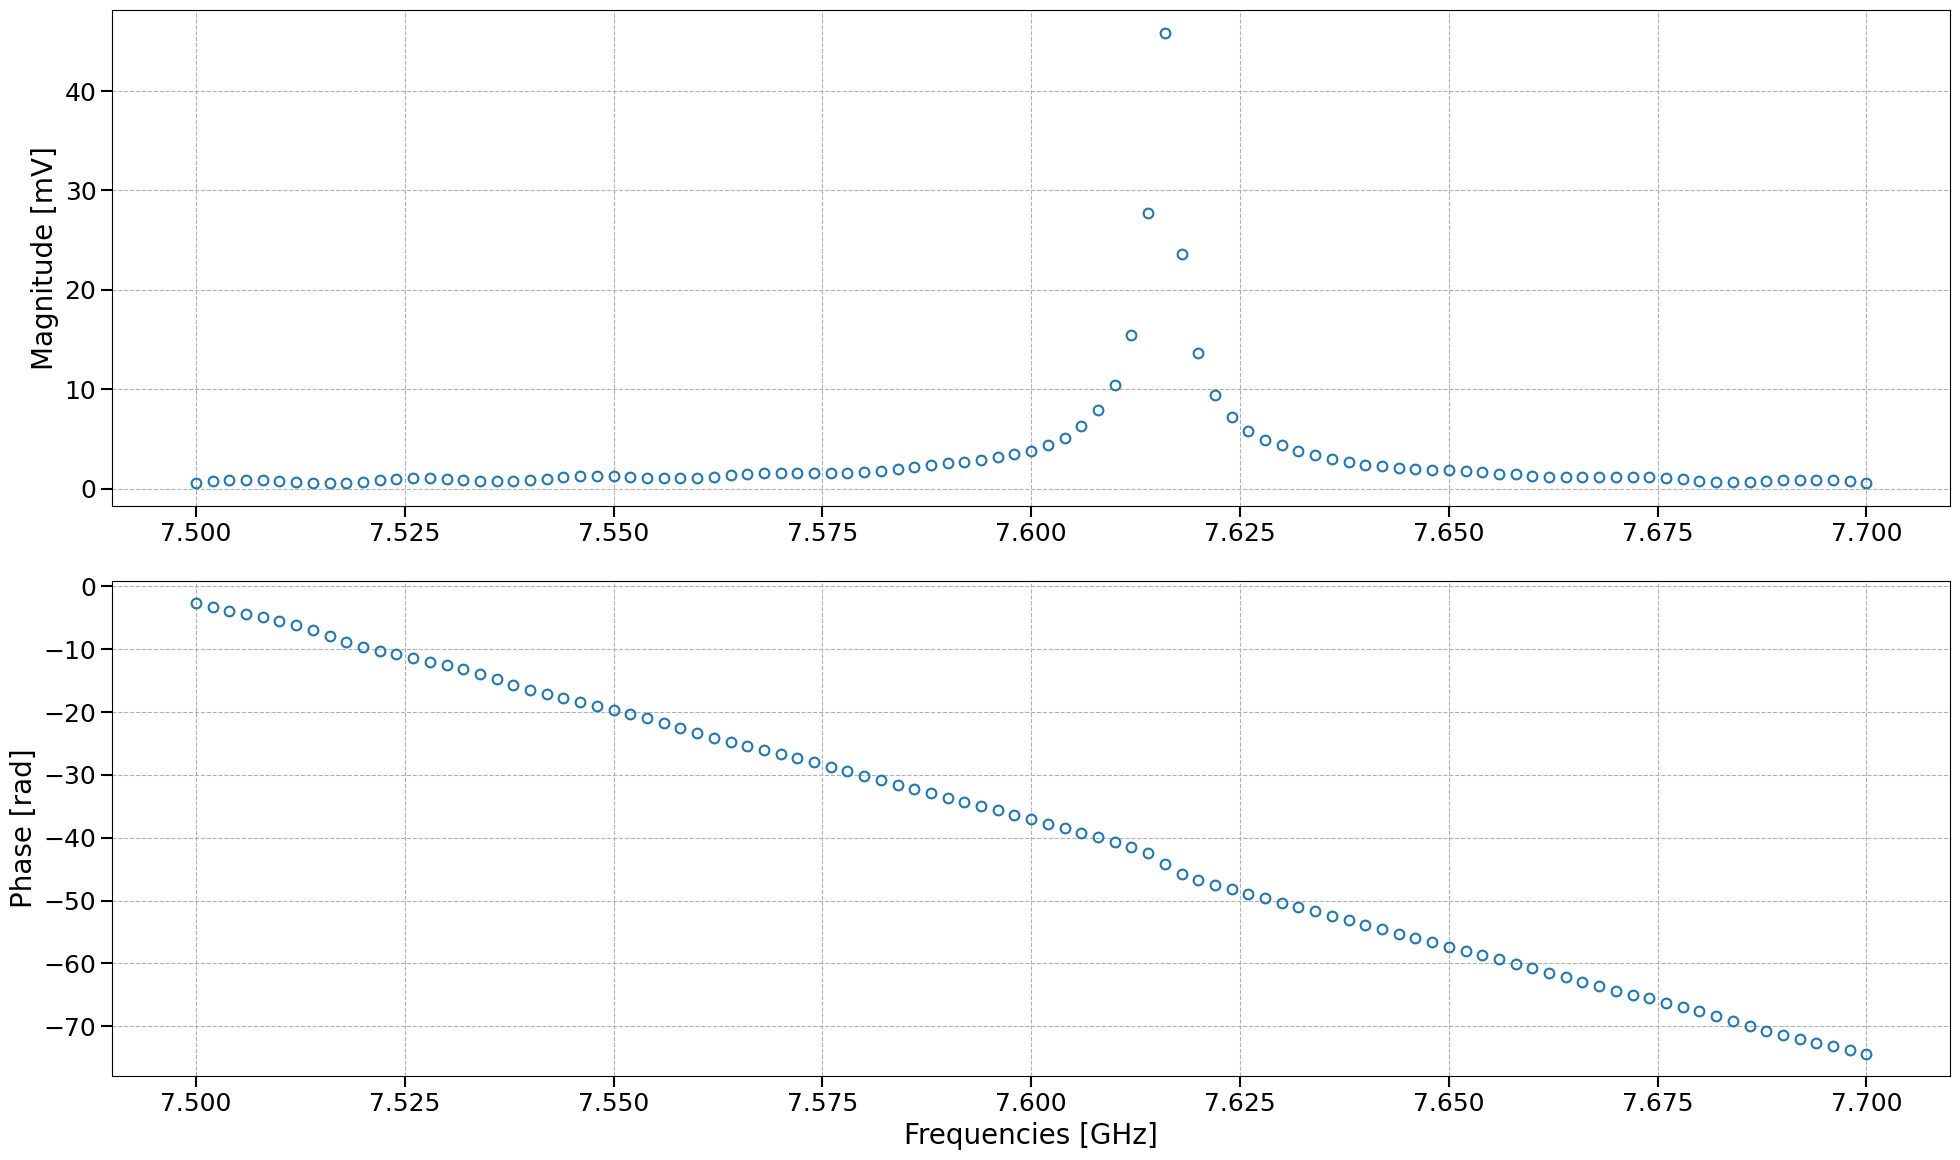

In [7]:
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])
x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])

sqil.set_plot_style(plt)
fig, axs = plt.subplots(2,1, figsize=(20, 12), sharex=True)

x_data_scaled = x_data * x_info.scale
y_data_scaled = y_data * y_info.scale

axs[0].plot(x_data_scaled, np.abs(y_data_scaled), "o")
axs[0].set_ylabel("Magnitude" + f" [{y_info.rescaled_unit}]" if y_info.unit else "")
axs[0].tick_params(labelbottom=True)
axs[0].xaxis.set_tick_params(which="both", labelbottom=True)  # Redundant for safety

axs[1].plot(x_data_scaled, np.unwrap(np.angle(y_data_scaled)), 'o')
axs[1].set_xlabel(x_info.name_and_unit)
axs[1].set_ylabel("Phase [rad]")

fig.tight_layout()
plt.show()

In [8]:
# path = r"Z:\Projects\BottomLoader\data\test\2025-07-02\00303-resonator_spectroscopy_2025-07-02T152841"
path = r"Z:\Projects\BottomLoader\data\test\2025-07-03\00304-resonator_spectroscopy_2025-07-03T152846"
datadict = sqil.extract_h5_data(path)
schema = {
    "data": {"role": "data", "unit": "V", "scale": 1e3},
    "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
    "sweep0": {"role": "axis", "id": "readout_amplitude"},
    # "sweep1": {"role": "axis", "id": "readout_range_in"},
}
datadict = {**datadict, "schema": schema}  # FIXME: remove line in prod

x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)

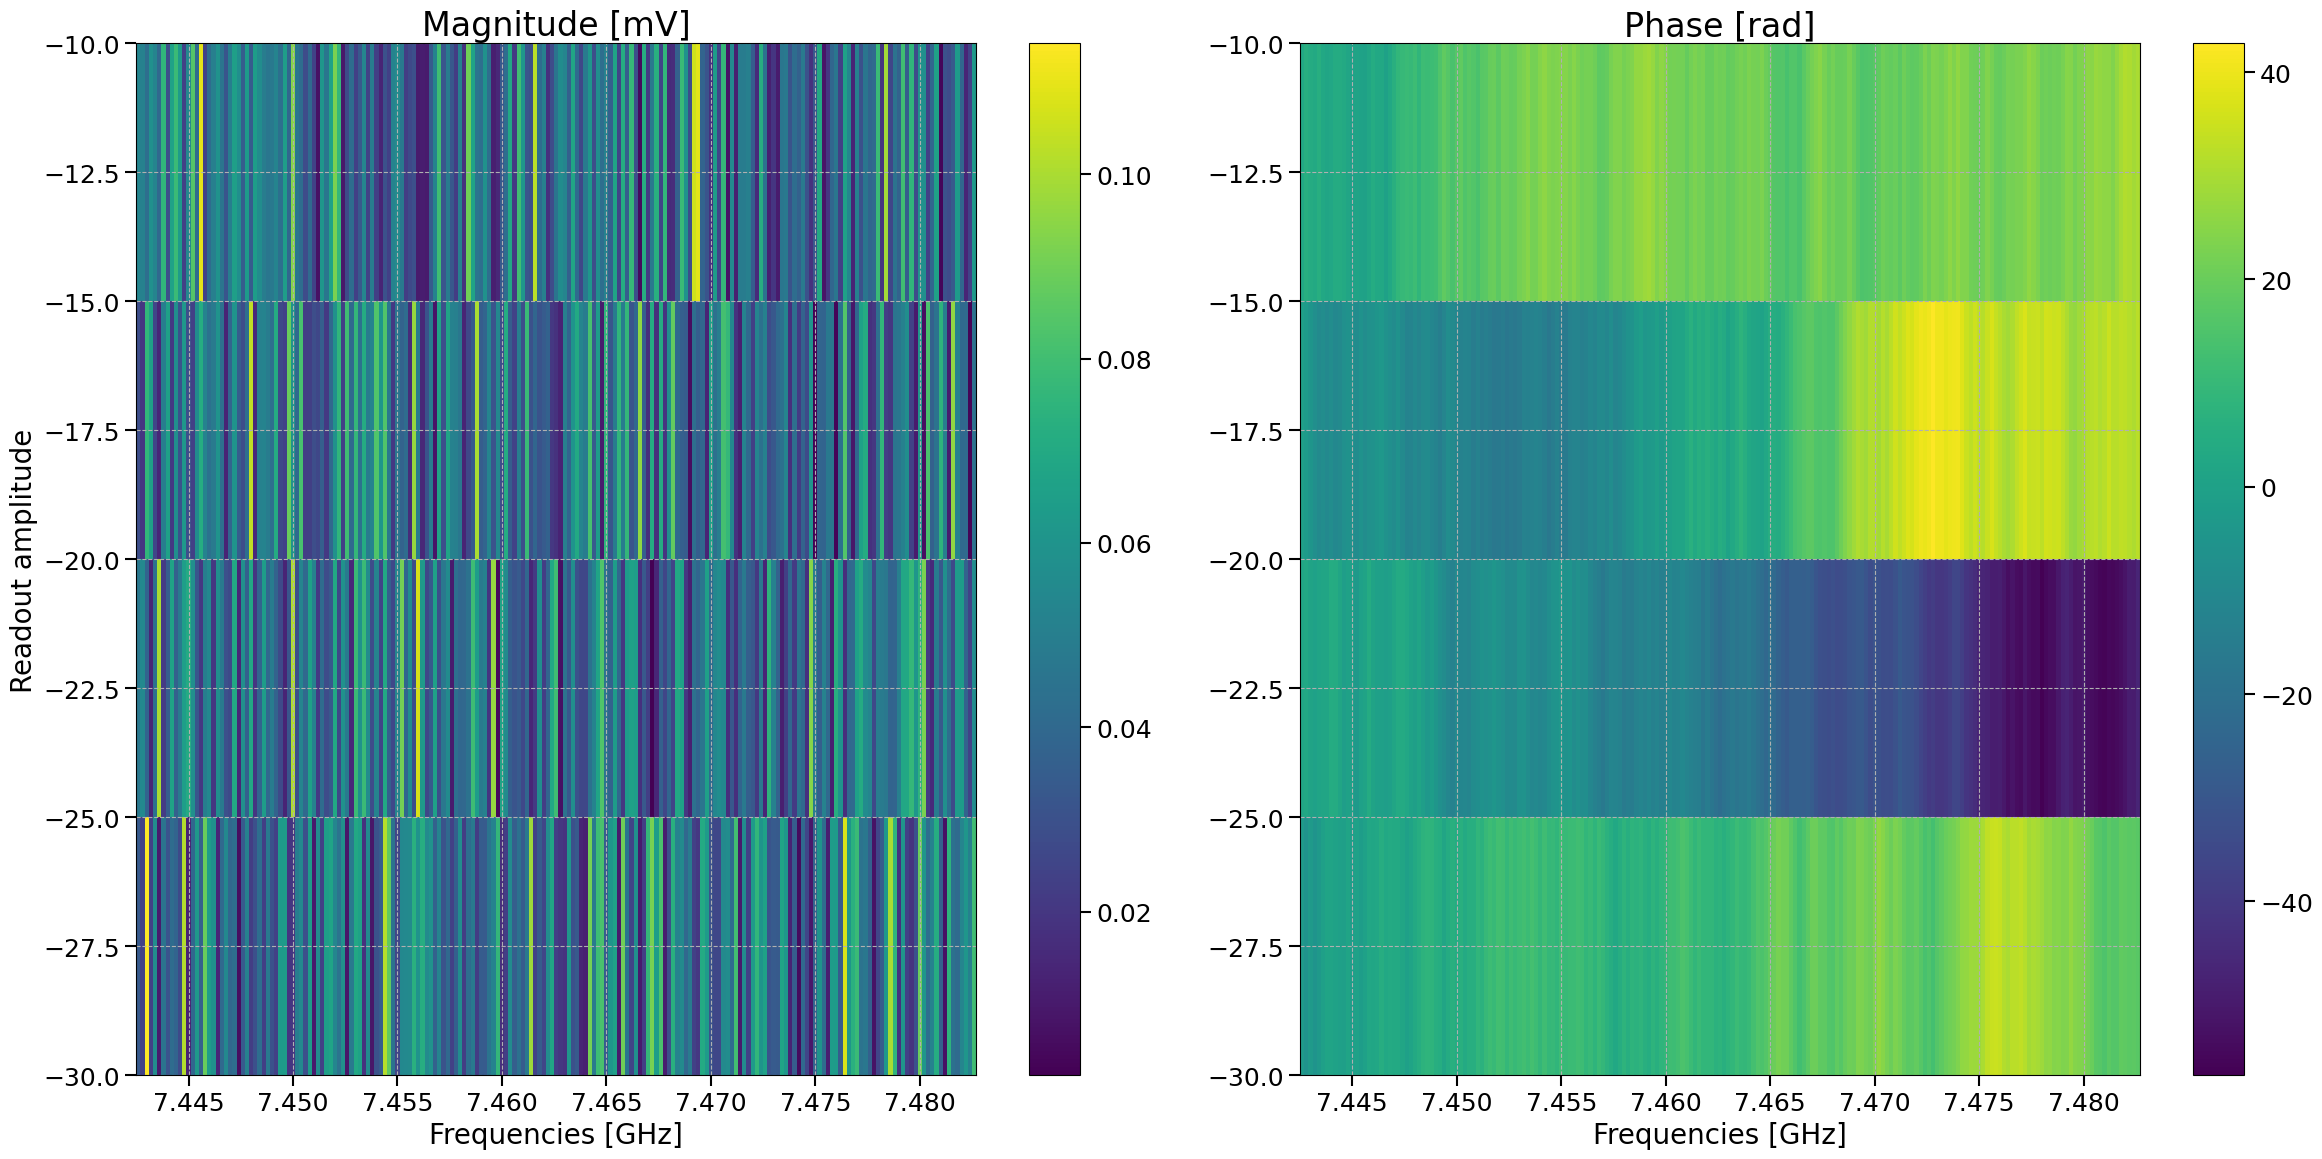

In [9]:
x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

x_data_scaled = x_data * x_info.scale
y_data_scaled = y_data * y_info.scale

sqil.set_plot_style(plt)
fig, axs = plt.subplots(1, 2, figsize=(24, 12), sharex=True, sharey=True)

sweep_key = datadict_map["sweeps"][0]
sweep0_info = param_info_from_schema(sweep_key, schema[sweep_key])
sweep0_scaled = sweeps[0] * sweep0_info.scale

c0 = axs[0].pcolormesh(x_data_scaled, sweep0_scaled, np.abs(y_data_scaled), shading="auto")
fig.colorbar(c0, ax=axs[0])
axs[0].set_title("Magnitude" + f" [{y_info.rescaled_unit}]" if y_info.unit else "")
axs[0].set_xlabel(x_info.name_and_unit)
axs[0].set_ylabel(sweep0_info.name_and_unit)

c1 = axs[1].pcolormesh(x_data_scaled, sweep0_scaled, np.unwrap(np.angle(y_data_scaled)), shading="auto")
fig.colorbar(c1, ax=axs[1])
axs[1].set_title("Phase [rad]")
axs[1].set_xlabel(x_info.name_and_unit)
axs[1].tick_params(labelleft=True)
axs[1].xaxis.set_tick_params(which="both", labelleft=True) # Redundant for safety


fig.tight_layout()
plt.show()

In [9]:
def plot_mag_phase(path=None, datadict=None):
    if path is None and datadict is None:
        raise Exception("At least one of `path` and `datadict` must be specified.")

    if path is not None:
        datadict = sqil.extract_h5_data(path)
    schema = { # FIXME: remove line in prod
        "data": {"role": "data", "unit": "V", "scale": 1e3},
        "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
        "sweep0": {"role": "axis", "id": "readout_amplitude"},
        # "sweep1": {"role": "axis", "id": "readout_range_in"},
    }
    datadict = {**datadict, "schema": schema}  # FIXME: remove line in prod

    x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)

    x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
    y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

    x_data_scaled = x_data * x_info.scale
    y_data_scaled = y_data * y_info.scale

    sqil.set_plot_style(plt)

    if len(sweeps) == 0: # 1D plot
        fig, axs = plt.subplots(2,1, figsize=(20, 12), sharex=True)

        x_data_scaled = x_data * x_info.scale
        y_data_scaled = y_data * y_info.scale

        axs[0].plot(x_data_scaled, np.abs(y_data_scaled), "o")
        axs[0].set_ylabel("Magnitude" + f" [{y_info.rescaled_unit}]" if y_info.unit else "")
        axs[0].tick_params(labelbottom=True)
        axs[0].xaxis.set_tick_params(which="both", labelbottom=True)  # Redundant for safety

        axs[1].plot(x_data_scaled, np.unwrap(np.angle(y_data_scaled)), 'o')
        axs[1].set_xlabel(x_info.name_and_unit)
        axs[1].set_ylabel("Phase [rad]")
    else: # 2D plot
        fig, axs = plt.subplots(1, 2, figsize=(24, 12), sharex=True, sharey=True)

        sweep_key = datadict_map["sweeps"][0]
        sweep0_info = param_info_from_schema(sweep_key, schema[sweep_key])
        sweep0_scaled = sweeps[0] * sweep0_info.scale

        c0 = axs[0].pcolormesh(
            x_data_scaled, sweep0_scaled, np.abs(y_data_scaled), shading="auto"
        )
        fig.colorbar(c0, ax=axs[0])
        axs[0].set_title("Magnitude" + f" [{y_info.rescaled_unit}]" if y_info.unit else "")
        axs[0].set_xlabel(x_info.name_and_unit)
        axs[0].set_ylabel(sweep0_info.name_and_unit)

        c1 = axs[1].pcolormesh(
            x_data_scaled, sweep0_scaled, np.unwrap(np.angle(y_data_scaled)), shading="auto"
        )
        fig.colorbar(c1, ax=axs[1])
        axs[1].set_title("Phase [rad]")
        axs[1].set_xlabel(x_info.name_and_unit)
        axs[1].tick_params(labelleft=True)
        axs[1].xaxis.set_tick_params(which="both", labelleft=True)  # Redundant for safety

    fig.tight_layout()
    return fig, axs

{'data': {'role': 'data', 'unit': 'V'}, 'frequencies': {'role': 'x-axis', 'unit': 'Hz'}, 'sweep0': {'role': 'axis', 'name': 'readout_amplitude'}}
Error fitting the complex resonator data: Tua mamma
Trying to fit just the magnitude
Error fitting the magnitude: At least one of `path` and `datadict` must be specified.
fr 7615767682.208614


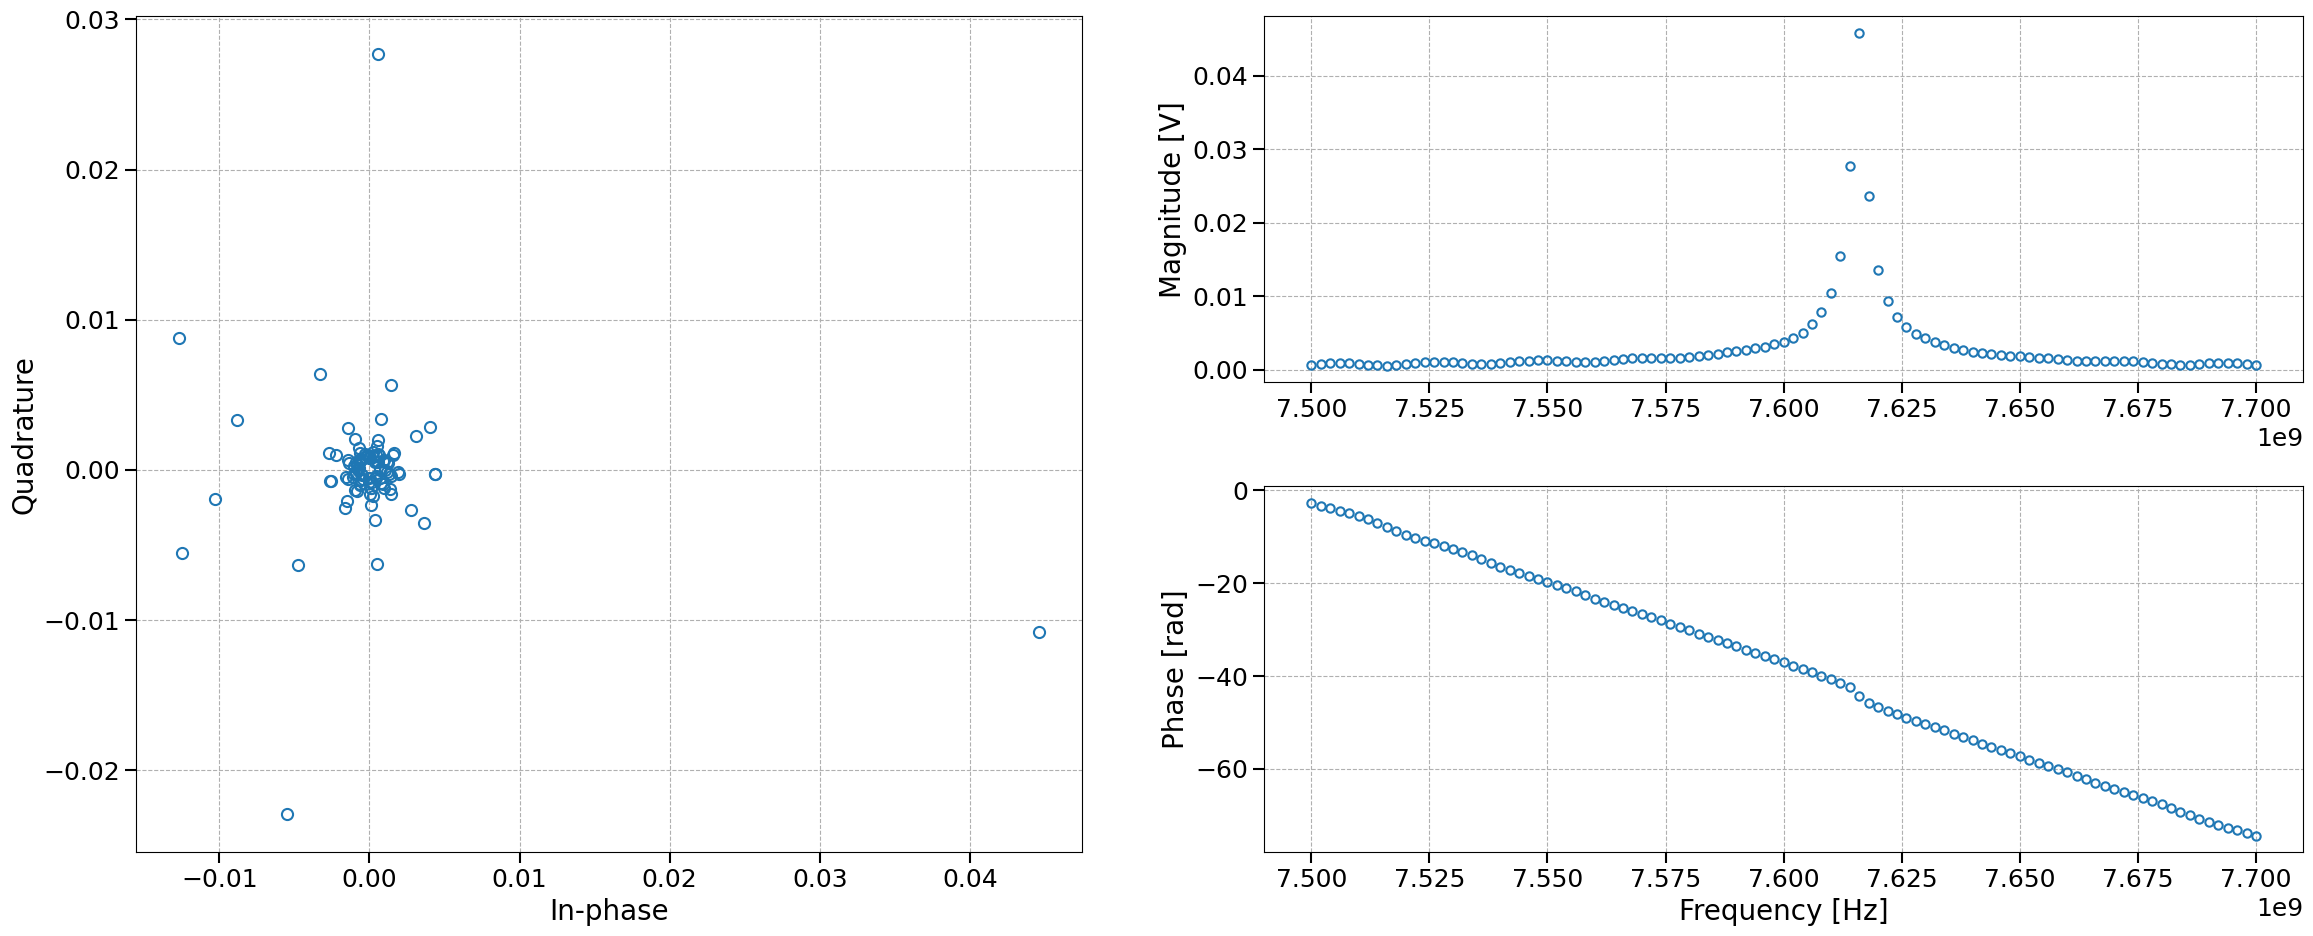

In [11]:
import sqil_core as sqil
import numpy as np
import matplotlib.pyplot as plt

path = r"Z:\Projects\BottomLoader\data\test\2025-07-02\00303-resonator_spectroscopy_2025-07-02T152841"
measurement = 'transmission'

data_dict = sqil.extract_h5_data(path, schema=True)
schema = data_dict.get("schema", None)
print(schema)
def map_data_dict(data_dict):
    schema = data_dict.get("schema", None)
    if schema is None:
        print(
            "Cannot automatically read data: no database schema was provided by the experiment."
        )

    x_data, y_data, sweeps = np.array([]), np.array([]), []
    key_map = {"x_data": "", "y_data": "", "sweeps": []}

    for key, value in schema.items():
        if type(value) is not dict:
            continue
        role = value.get("role", None)
        if role == "data":
            key_map["y_data"] = key
            y_data = data_dict[key]
        elif role == "x-axis":
            key_map["x_data"] = key
            x_data = data_dict[key]
        elif role == "axis":
            key_map["sweeps"].append(key)
            sweeps.append(data_dict[key])

    return x_data, y_data, sweeps, key_map


x_data, y_data, sweeps, data_dict_map = map_data_dict(data_dict)


path = r"Z:\Projects\BottomLoader\data\test\data\2025-05-13\00077-rr spectroscopy_2025-05-13T210835"
y_data, x_data = sqil.extract_h5_data(path, ["data", "frequencies"])
# y_data = y_data[0:20]
# x_data = x_data[0:20]

x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

x_data_scaled = x_data * x_info.scale
y_data_scaled = y_data * y_info.scale

has_sweeps = str(y_data.ndim)

updated_params = {}

if has_sweeps == '1':
    # If dB convert to linear magnitude for the fit
    y_unit = y_info.unit
    if y_unit == 'dB':
        y_data = 10 ** (np.abs(y_data) / 20) * np.exp(1j*np.angle(y_data))
        y_unit = 'V'

    # Fit data to extract parameters
    fr = None
    try:
        raise Exception("Tua mamma")
        # Quick resonator fit to get parameter guesses
        guess = sqil.resonator.quick_fit(x_data, y_data, measurement)
        # Full resonator fit
        fit_res = sqil.resonator.full_fit(x_data, y_data, measurement, *guess)
        if fit_res.metrics['nrmse'] > 0.1:
            raise Exception(f"Bad fit, nrmse = {fit_res.metrics['nrmse']:.4f} is too high")
        fr = fit_res.params_by_name["fr"]
        # Plot
        x_fit = np.linspace(x_data[0], x_data[-1], np.max([2000, len(x_data)]))
        sqil.resonator.plot_resonator(x_data, y_data, x_fit, fit_res.predict(x_fit))
    except Exception as e:
        print(f"Error fitting the complex resonator data:", e)
        print(f"Trying to fit just the magnitude")
        try:
            fit_res = sqil.resonator.linmag_fit(x_data, y_data)
            if fit_res.metrics['nrmse'] > 0.1:
                raise Exception(f"Bad fit, nrmse = {fit_res.metrics['nrmse']:.4f} is too high")
            fr = fit_res.params_by_name["x0"]
            fig, axs = plot_mag_phase()
            # TODO: plot mag and phase
        except Exception as e2:
            print(f"Error fitting the magnitude:", e2)
            fit_res = None
            sqil.resonator.plot_resonator(x_data, y_data)

    print('fr', fr)

# if plot_dim == '2':
plt.show()

{'readout_resonator_frequency': np.float64(7615780020.104465), 'readout_kappa_tot': np.float64(2639869.587327296)}


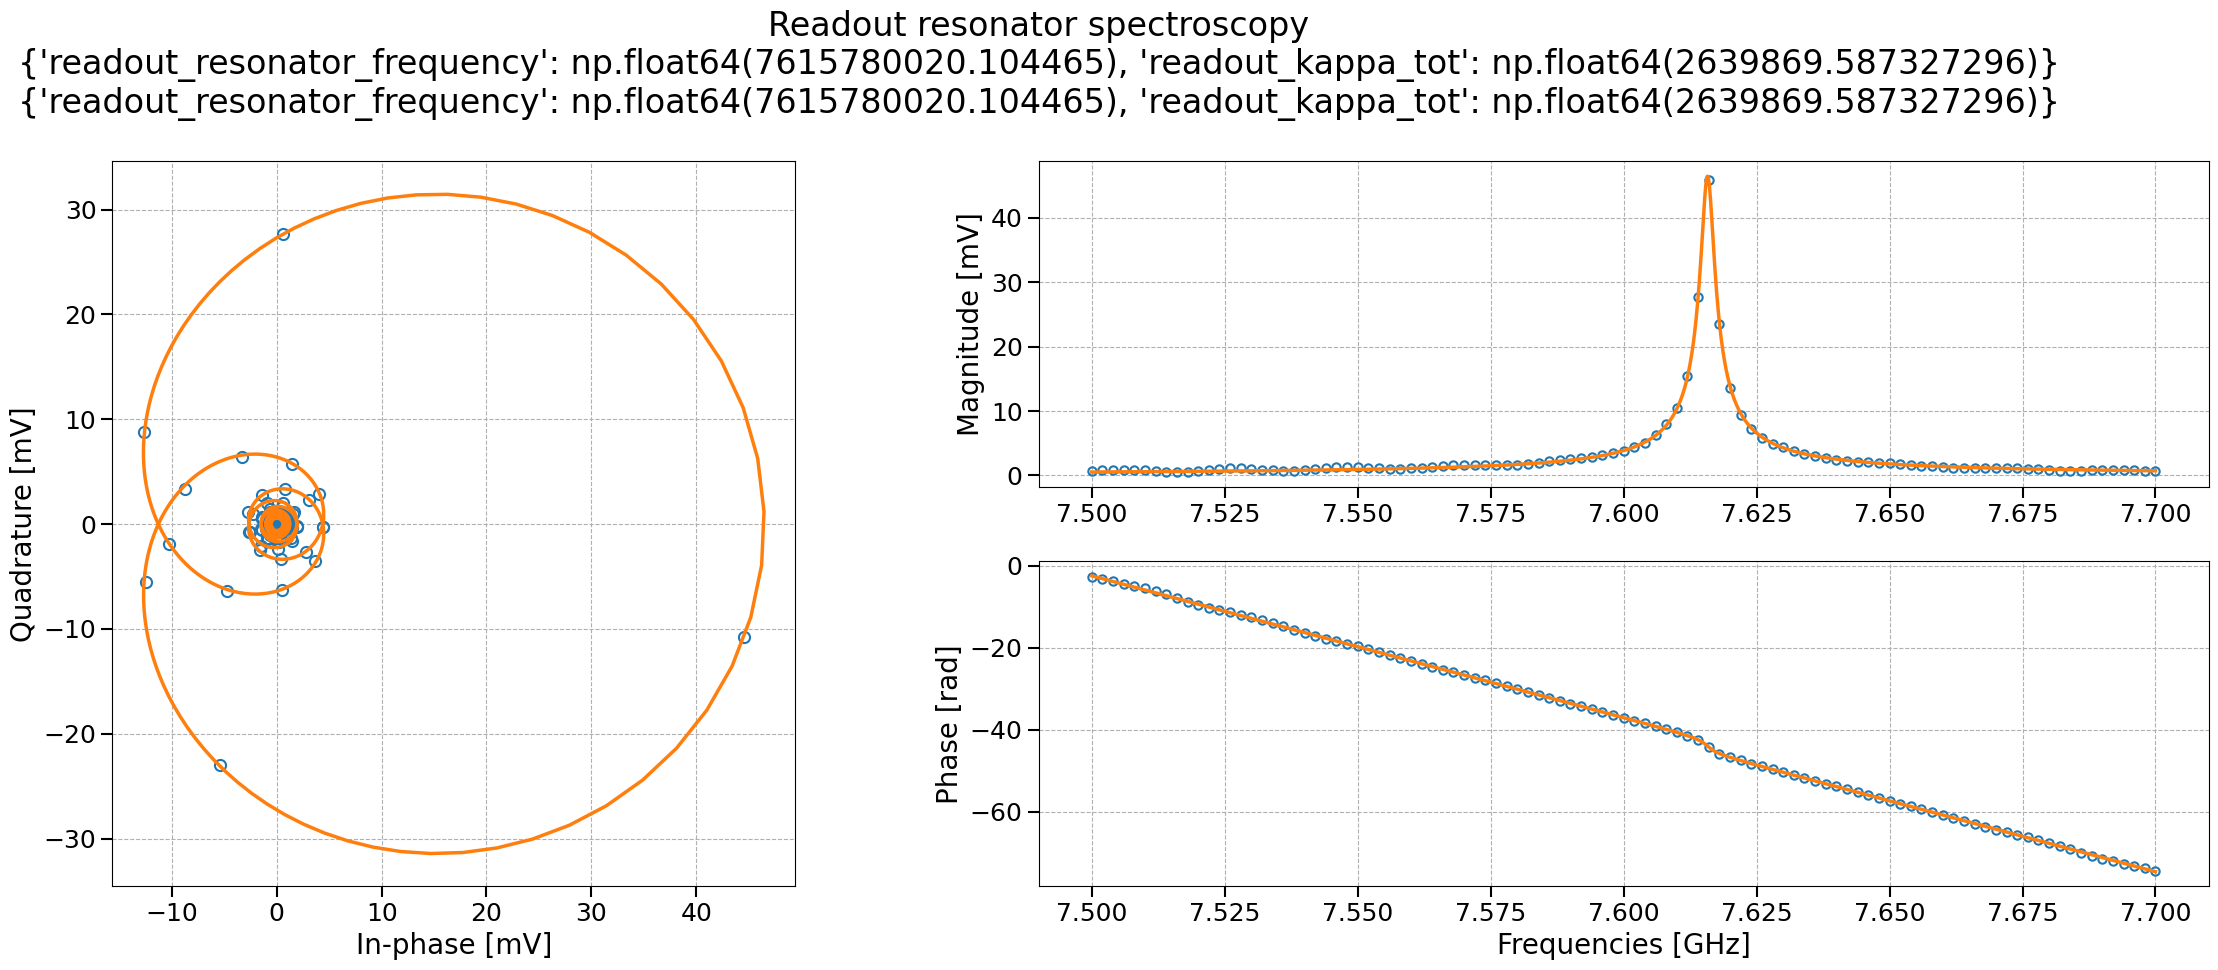

In [12]:
measurement = "transmission"

path = r"Z:\Projects\BottomLoader\data\test\data\2025-05-13\00077-rr spectroscopy_2025-05-13T210835"
datadict = sqil.extract_h5_data(path)
schema = {  # FIXME: remove line in prod
    "data": {"role": "data", "unit": "V", "scale": 1e3},
    "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
    # "sweep0": {"role": "axis", "id": "readout_amplitude"},
    # "sweep1": {"role": "axis", "id": "readout_range_in"},
}
datadict = {**datadict, "schema": schema}  # FIXME: remove line in prod

x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)
x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

x_data_scaled = x_data * x_info.scale
y_data_scaled = y_data * y_info.scale

has_sweeps = y_data.ndim > 1

if not has_sweeps:
    y_unit = y_info.unit
    y_scale = y_info.scale

    # If dB convert to linear magnitude for the fit
    if y_unit == "dB":
        y_data = 10 ** (np.abs(y_data) / 20) * np.exp(1j * np.angle(y_data))
        y_unit = "V"
    y_unit_str = f" [{rescale_unit(y_unit, y_scale)}]" if y_unit else ""

    # Plot without fit
    fig, axs = sqil.resonator.plot_resonator(x_data_scaled, y_data_scaled)
    # Fix axis names
    axs[0].set_xlabel("In-phase" + y_unit_str)
    axs[0].set_ylabel("Quadrature" + y_unit_str)
    axs[1].set_ylabel("Magnitude" + y_unit_str)
    axs[2].set_xlabel(x_info.name_and_unit)

    # Fit data to extract parameters
    updated_params = {}
    try:
        # raise Exception("Your mom")
        # Quick resonator fit to get parameter guesses
        guess = sqil.resonator.quick_fit(x_data, y_data, measurement)
        # Full resonator fit
        fit_res = sqil.resonator.full_fit(x_data, y_data, measurement, *guess)
        if not fit_res.is_acceptable("nrmse"):
            raise Exception(
                f"Bad fit with {fit_res.model_name} model, nrmse = {fit_res.metrics['nrmse']:.4f} is too high"
            )
        # Extract parameters
        fr = fit_res.params_by_name["fr"]
        updated_params["readout_resonator_frequency"] = fr
        updated_params["readout_kappa_tot"] = fr / fit_res.params_by_name["Q_tot"]
        # Plot
        x_fit = np.linspace(x_data[0], x_data[-1], np.max([2000, len(x_data)]))
        y_fit_scaled = fit_res.predict(x_fit) * y_info.scale
        axs[0].plot(np.real(y_fit_scaled), np.imag(y_fit_scaled), color="tab:orange")
        axs[1].plot(x_fit*x_info.scale, np.abs(y_fit_scaled), color="tab:orange")
        axs[2].plot(x_fit*x_info.scale, np.unwrap(np.angle(y_fit_scaled)), color="tab:orange")
    except Exception as e:
        print(f"Error fitting the complex resonator data:", e)
        print(f"Trying to fit just the magnitude")
        try:
            fit_res = sqil.resonator.linmag_fit(x_data, y_data)
            if not fit_res.is_acceptable('nrmse'):
                raise Exception(
                    f"Bad fit, nrmse = {fit_res.metrics['nrmse']:.4f} is too high"
                )
            updated_params["readout_resonator_frequency"] = fit_res.params_by_name["x0"]
            # Plot
            x_fit = np.linspace(x_data[0], x_data[-1], np.max([2000, len(x_data)]))
            y_fit = np.sqrt(fit_res.predict(x_fit)) * np.max(np.abs(y_data))
            axs[1].plot(x_fit*x_info.scale, y_fit*y_info.scale, color='tab:orange')
        except Exception as e2:
            print(f"Error fitting the magnitude:", e2)
            fit_res = None

    print(updated_params)


    fig.suptitle("Readout resonator spectroscopy\n" + str(updated_params) + "\n" + str(updated_params))
    fig.tight_layout()

    # if fit_res is not None:
    #     # w, h = fig.get_size_inches()
    #     # fig.set_size_inches(w, h+10)
    #     # fig.subplots_adjust(bottom=0.6)  # if needed to make space
    #     fit_str = f"Model: {fit_res.model_name}\nQuality: {str(fit_res.quality())}"
    #     fig.text(0.02, -0.04, fit_str, ha="left")

    #     fit_str = updated_params
    #     fig.text(0.3, -0.04, fit_str, ha="left")
    #     pass

plt.show()

In [6]:
import os
from laboneq import serializers
import warnings
import attrs

path = r"Z:\Projects\BottomLoader\data\test\2025-07-03\00304-resonator_spectroscopy_2025-07-03T152846"

def read_qpu(dir_path, filename):
    qpu = serializers.load(os.path.join(dir_path, filename))
    return qpu

ParamDict = dict[str, ParamInfo]


def enrich_qubit_params(qubit) -> ParamDict:
    qubit_params = attrs.asdict(qubit.parameters)
    res = {}
    for key, value in qubit_params.items():
        res[key] = ParamInfo(key, value)
    return res

In [7]:
qpu = read_qpu(path, "qpu_old.json")
qubit_params = enrich_qubit_params(qpu.quantum_elements[0])

exp_params = [param for param in ONE_TONE_PARAMS if param not in data_dict_map['sweeps']]
params_str = ",   ".join([qubit_params[id].symbol_and_value for id in exp_params])

NameError: name 'data_dict_map' is not defined

In [12]:
# exp_params = [
#     param for param in ONE_TONE_PARAMS if param not in data_dict_map["sweeps"]
# ]
# params_str = ",   ".join([qubit_params[id].symbol_and_value for id in exp_params])


def get_relevant_exp_parameters(qubit_params: ParamDict, exp_param_ids, sweep_ids):
    # Filter out sweeps
    filtered = [id for id in exp_param_ids if id not in sweep_ids]

    # Handle special cases
    for id in filtered:
        if id == "readout_resonator_frequency":
            # Remove LO information if not relevant
            ext_lo_freq = qubit_params.get("external_lo_frequency")
            if not ext_lo_freq:
                parms_to_exclude = ["external_lo_frequency", "external_lo_power"]
                filtered = [id for id in filtered if id not in parms_to_exclude]

    return {key: value for key, value in qubit_params.items() if key in filtered}

### Analyze and plot

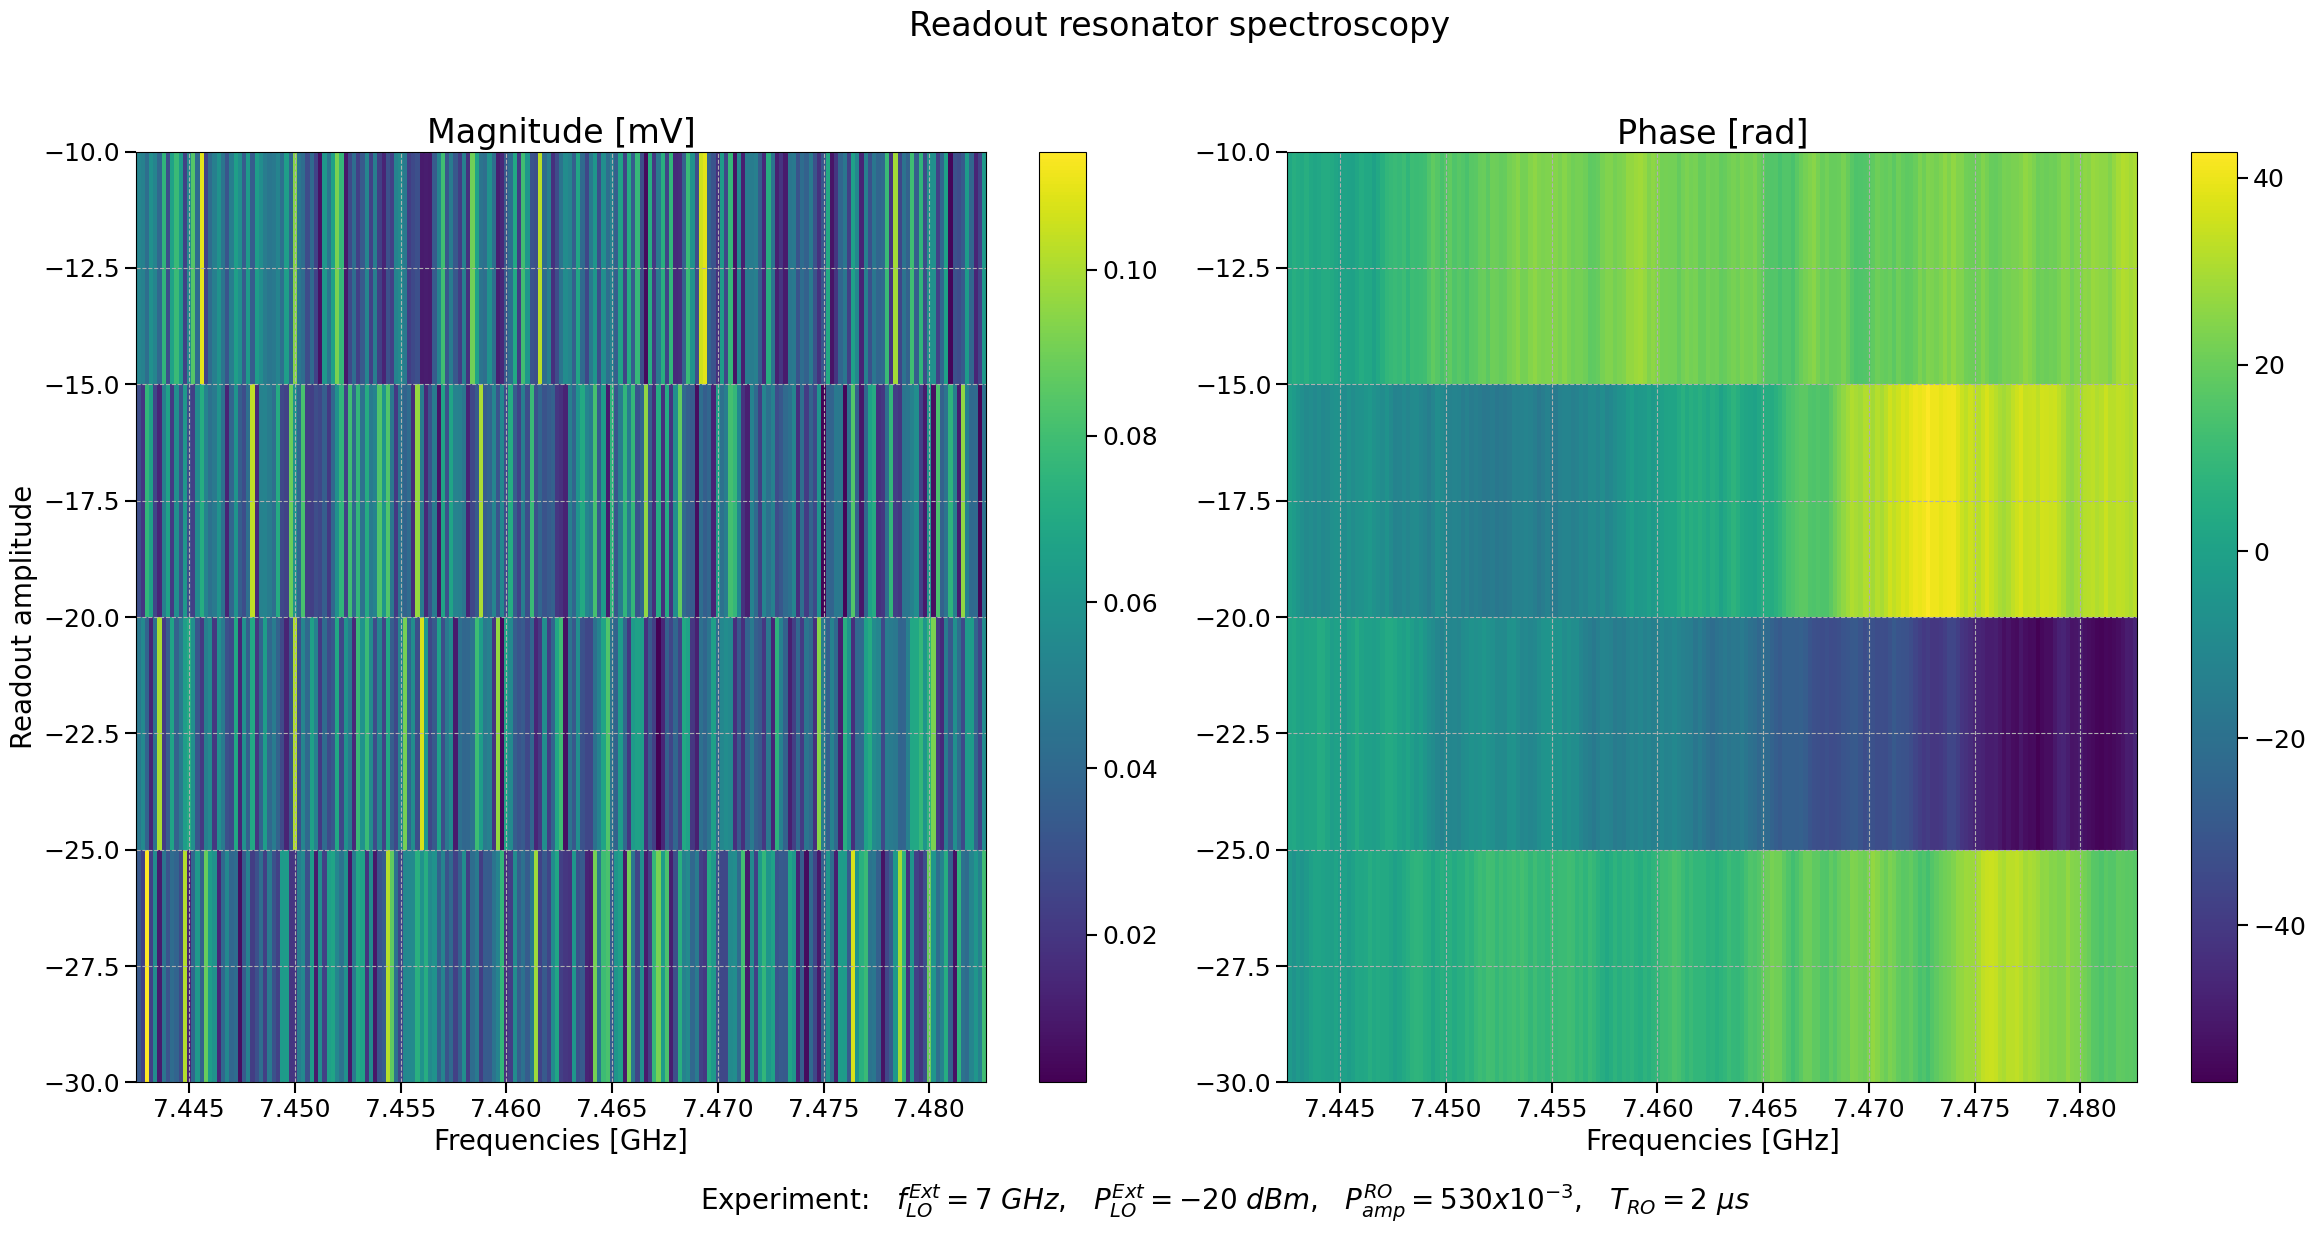

In [18]:
path = r"Z:\Projects\BottomLoader\data\test\data\2025-05-13\00077-rr spectroscopy_2025-05-13T210835"
path = r"Z:\Projects\BottomLoader\data\test\2025-07-03\00304-resonator_spectroscopy_2025-07-03T152846"

datadict = sqil.extract_h5_data(path) # FIXME: schema = True

#####################
schema = {  # FIXME: remove line in prod
    "data": {"role": "data", "unit": "V", "scale": 1e3},
    "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
    "sweep0": {"role": "axis", "id": "readout_amplitude"},
    # "sweep1": {"role": "axis", "id": "readout_range_in"},
}
datadict = {**datadict, "schema": schema}  # FIXME: remove line in prod
#######################

x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)
x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

x_data_scaled = x_data * x_info.scale
y_data_scaled = y_data * y_info.scale

# Extract qubit parameters
qubit_params = {}
try:
    path_q = (
        r"Z:\Projects\BottomLoader\data\test\2025-07-03\00304-resonator_spectroscopy_2025-07-03T152846"
    ) # FIXME: remove line in prod
    qpu = read_qpu(path_q, "qpu_old.json") # FIXME: just path
    qubit_params = enrich_qubit_params(qpu.quantum_elements[0])
except Exception as e:
    print("Error reading QPU", e)
measurement = qubit_params["readout_configuration"].value
updated_params = {}
fit_res = None

has_sweeps = y_data.ndim > 1

if not has_sweeps:
    y_unit = y_info.unit
    y_scale = y_info.scale

    # If dB convert to linear magnitude for the fit
    if y_unit == "dB":
        y_data = 10 ** (np.abs(y_data) / 20) * np.exp(1j * np.angle(y_data))
        y_unit = "V"
    y_unit_str = f" [{rescale_unit(y_unit, y_scale)}]" if y_unit else ""

    # Plot without fit
    fig, axs = sqil.resonator.plot_resonator(x_data_scaled, y_data_scaled)
    # Fix axis names
    axs[0].set_xlabel("In-phase" + y_unit_str)
    axs[0].set_ylabel("Quadrature" + y_unit_str)
    axs[1].set_ylabel("Magnitude" + y_unit_str)
    axs[2].set_xlabel(x_info.name_and_unit)

    # Fit data to extract parameters
    try:
        # raise Exception("Your mom")
        # Quick resonator fit to get parameter guesses
        guess = sqil.resonator.quick_fit(x_data, y_data, measurement)
        # Full resonator fit
        fit_res = sqil.resonator.full_fit(x_data, y_data, measurement, *guess)
        if not fit_res.is_acceptable("nrmse"):
            raise Exception(
                f"Bad fit with {fit_res.model_name} model, nrmse = {fit_res.metrics['nrmse']:.4f} is too high"
            )
        # Extract parameters
        fr = fit_res.params_by_name["fr"]
        updated_params["readout_resonator_frequency"] = fr
        updated_params["readout_kappa_tot"] = fr / fit_res.params_by_name["Q_tot"]
        # Plot
        x_fit = np.linspace(x_data[0], x_data[-1], np.max([2000, len(x_data)]))
        y_fit_scaled = fit_res.predict(x_fit) * y_info.scale
        axs[0].plot(np.real(y_fit_scaled), np.imag(y_fit_scaled), color="tab:orange")
        axs[1].plot(x_fit * x_info.scale, np.abs(y_fit_scaled), color="tab:orange")
        axs[2].plot(
            x_fit * x_info.scale, np.unwrap(np.angle(y_fit_scaled)), color="tab:orange"
        )
    except Exception as e:
        print(f"Error fitting the complex resonator data:", e)
        print(f"Trying to fit just the magnitude")
        try:
            fit_res = sqil.resonator.linmag_fit(x_data, y_data)
            if not fit_res.is_acceptable("nrmse"):
                raise Exception(
                    f"Bad fit, nrmse = {fit_res.metrics['nrmse']:.4f} is too high"
                )
            updated_params["readout_resonator_frequency"] = fit_res.params_by_name["x0"]
            # Plot
            x_fit = np.linspace(x_data[0], x_data[-1], np.max([2000, len(x_data)]))
            y_fit = np.sqrt(fit_res.predict(x_fit)) * np.max(np.abs(y_data))
            axs[1].plot(x_fit * x_info.scale, y_fit * y_info.scale, color="tab:orange")
        except Exception as e2:
            print(f"Error fitting the magnitude:", e2)
            fit_res = None

    print(updated_params)
else:
    fig, axs = plot_mag_phase(datadict=datadict)


exp_params = get_relevant_exp_parameters(
    qubit_params, ONE_TONE_PARAMS, datadict_map["sweeps"]
)
params_str = ",   ".join([qubit_params[id].symbol_and_value for id in exp_params])

updated_params_info = {k: ParamInfo(k, v) for k,v in updated_params.items()}
update_params_str = ",   ".join(
    [updated_params_info[id].symbol_and_value for id in updated_params_info.keys()]
)

fig.suptitle(
    "Readout resonator spectroscopy\n" + update_params_str
)
if fit_res:
    fig.text(0.02, -0.02, f"Model: {fit_res.model_name} - {fit_res.quality()}")
fig.text(0.3, -0.02, "Experiment:   " + params_str, ha="left")
fig.tight_layout()

plt.show()

### Possible separation

In [17]:
def analyze_resonator_spectroscopy(x_data, y_data, x_info, y_info, measurement):
    results = {
        "x_data_scaled": x_data * x_info.scale,
        "y_data_scaled": y_data * y_info.scale,
        "updated_params": {},
        "fit_result": None,
        "fit_data": None,
    }

    # If dB convert to linear magnitude
    y_data_processed = y_data
    y_unit = y_info.unit
    if y_unit == "dB":
        y_data_processed = 10 ** (np.abs(y_data) / 20) * np.exp(1j * np.angle(y_data))
        y_unit = "V"

    try:
        guess = sqil.resonator.quick_fit(x_data, y_data_processed, measurement)
        fit_res = sqil.resonator.full_fit(x_data, y_data_processed, measurement, *guess)
        if not fit_res.is_acceptable("nrmse"):
            raise Exception(f"Poor full_fit nrmse={fit_res.metrics['nrmse']:.4f}")
        fr = fit_res.params_by_name["fr"]
        results["updated_params"]["readout_resonator_frequency"] = fr
        results["updated_params"]["readout_kappa_tot"] = (
            fr / fit_res.params_by_name["Q_tot"]
        )

        x_fit = np.linspace(x_data[0], x_data[-1], max(2000, len(x_data)))
        y_fit_scaled = fit_res.predict(x_fit) * y_info.scale
        results["fit_result"] = fit_res
        results["fit_data"] = (x_fit * x_info.scale, y_fit_scaled)
    except Exception as e1:
        print("Error in full_fit:", e1)
        try:
            fit_res = sqil.resonator.linmag_fit(x_data, y_data_processed)
            if not fit_res.is_acceptable("nrmse"):
                raise Exception(f"Poor linmag_fit nrmse={fit_res.metrics['nrmse']:.4f}")
            x_fit = np.linspace(x_data[0], x_data[-1], max(2000, len(x_data)))
            y_fit = np.sqrt(fit_res.predict(x_fit)) * np.max(np.abs(y_data))
            results["updated_params"]["readout_resonator_frequency"] = (
                fit_res.params_by_name["x0"]
            )
            results["fit_result"] = fit_res
            results["fit_data"] = (x_fit * x_info.scale, y_fit * y_info.scale)
        except Exception as e2:
            print("Error in linmag_fit:", e2)

    return results


def plot_resonator_spectroscopy(
    x_data_scaled, y_data_scaled, x_info, y_info, fit_data=None
):
    y_unit_str = f" [{rescale_unit(y_info.unit, y_info.scale)}]" if y_info.unit else ""
    fig, axs = sqil.resonator.plot_resonator(x_data_scaled, y_data_scaled)

    axs[0].set_xlabel("In-phase" + y_unit_str)
    axs[0].set_ylabel("Quadrature" + y_unit_str)
    axs[1].set_ylabel("Magnitude" + y_unit_str)
    axs[2].set_xlabel(x_info.name_and_unit)
    fig.suptitle("Readout resonator spectroscopy")

    if fit_data:
        x_fit, y_fit = fit_data
        axs[0].plot(np.real(y_fit), np.imag(y_fit), color="tab:orange")
        axs[1].plot(x_fit, np.abs(y_fit), color="tab:orange")
        axs[2].plot(x_fit, np.unwrap(np.angle(y_fit)), color="tab:orange")

    fig.tight_layout()
    return fig, axs

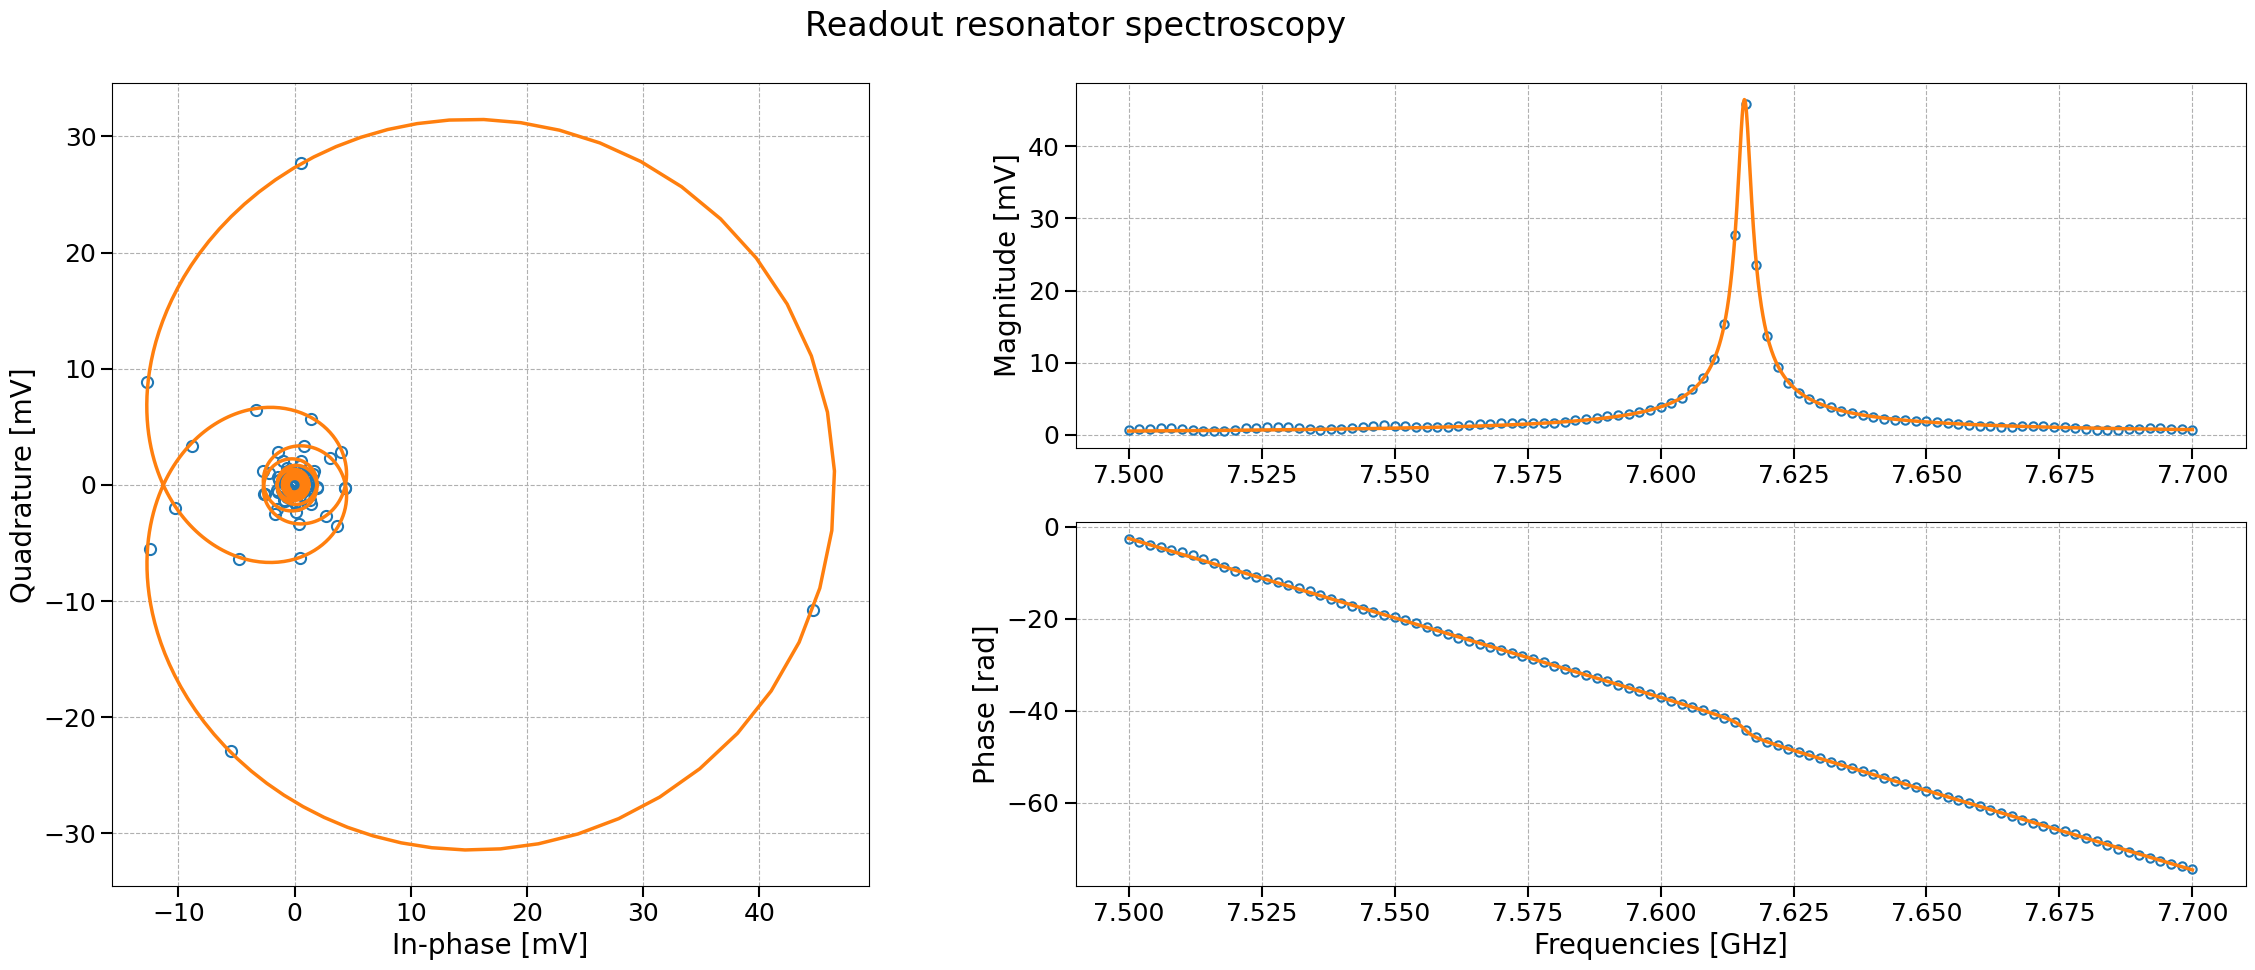

In [18]:
measurement = "transmission"

path = r"Z:\Projects\BottomLoader\data\test\data\2025-05-13\00077-rr spectroscopy_2025-05-13T210835"
datadict = sqil.extract_h5_data(path)
schema = {  # FIXME: remove line in prod
    "data": {"role": "data", "unit": "V", "scale": 1e3},
    "frequencies": {"role": "x-axis", "unit": "Hz", "scale": 1e-9},
    # "sweep0": {"role": "axis", "id": "readout_amplitude"},
    # "sweep1": {"role": "axis", "id": "readout_range_in"},
}
datadict = {**datadict, "schema": schema}  # FIXME: remove line in prod

x_data, y_data, sweeps, datadict_map = map_data_dict(datadict)
x_info = param_info_from_schema(datadict_map["x_data"], schema[datadict_map["x_data"]])
y_info = param_info_from_schema(datadict_map["y_data"], schema[datadict_map["y_data"]])

# Analyze
results = analyze_resonator_spectroscopy(x_data, y_data, x_info, y_info, measurement)

# Plot
fig, axs = plot_resonator_spectroscopy(
    results["x_data_scaled"],
    results["y_data_scaled"],
    x_info,
    y_info,
    fit_data=results["fit_data"],
)

plt.show()